# Overview

This Notebook is split into a few parts. The first cell is all raw data - it contains:

* The amount of XP needed to progress between specific levels, collected by hand
* XP gained for various activities. An array if used if XP is dependent on current streak or grade
* Gold gains for hourglass or emissary flags, and gold costs for supplies

After the data cell, code cells are used for:

1. Fitting a curve to the "til next level" data.
2. Fitting multiple curves to the "hourglass value" data. This is a work-in-progress.
3. IPython widgets can be used to adjust a scale and zoom into specific "til next level" ranges and estimate the required effort to progress.
4. A 1000-iteration simulator can be used to more accurately predict effort required to progress, based on win rate, flag rate, and other variables.

In [16]:
from IPython.display import display, Markdown

# [(level, XP til next level)]
# Mix of data collected by SansSariph, Lucc5822
# and /u/OndrejBakan's spreadsheet here: https://docs.google.com/spreadsheets/d/1YsY5B0N_-uSPwLl3RglJjW_pclCSkYcqVx3-BbMx3AQ/view#gid=1095730314
zippedData = [
    (1, 2000), 
    (2, 3278), 
    (3, 4033), 
    (4, 4618),
    (5, 5108),
    (6, 5535), 
    (7, 5919), 
    (8, 6267), 
    (9, 6590), 
    (10, 6890), 
    (11, 7171), 
    (12, 7437), 
    (13, 7690), 
    (14, 7929), 
    (15, 8160), 
    (16, 8381), 
    (17, 8593), 
    (18, 8797), 
    (19, 8995), 
    (20, 9187), 
    (21, 9373), 
    (22, 9552),
    (23, 9728),
    (24, 9899),
    (25, 10065), 
    (26, 10227), 
    (27, 10386), 
    (28, 10541), 
    (29, 10693), 
    (30, 10842), 
    (31, 10986), 
    (32, 11130), 
    (33, 11270), 
    (34, 11407), 
    (35, 11542), 
    (36, 11674), 
    (37, 11805),
    (38, 11934),
    (39, 12060),
    (40, 12184),
    (41, 12306),
    (42, 12428),
    (43, 12546),
    (44, 12663),
    (45, 12779),
    (47, 13005),
    (48, 13117),
    (49, 13227),
    (50, 13335),
    (51, 13443),
    (53, 13652),
    (56, 13960),
    (58, 14159),
    (59, 14257),
    (60, 14353),
    (61, 14450),
    (62, 14545),
    (64, 14732),
    (65, 14825),
    (67, 15006),
    (68, 15097),
    (69, 15186),
    (73, 15535),
    (74, 15619),
    (75, 15705),
    (76, 15788),
    (77, 15872),
    (78, 15954),
    (79, 16036),
    (80, 16118),
    (81, 16198),
    (82, 16279),
    (83, 16359),
    (84, 16437),
    (85, 16516),
    (86, 16593),
    (87, 16672),
    (88, 16747),
    (89, 16825),
    (90, 16900),
    (91, 16975),
    (92, 17050),
    (93, 17124),
    (94, 17199),
    (95, 17271),
    (96, 17344),
    (97, 17417),
    (98, 17489),
    (99, 17650)
]

# Static requirement after level 100
AFTER_100 = 12600

# Allegiance/XP for losing a fight
GAIN_LOSS = 560

# Allegiance/XP for sinking another ship
# Index == streak
GAIN_WIN = [
    4200,
    4675,
    5160, # ?
    5688, # ?
    6600  # ?
]

# Allegiance/XP for cashing out an hourglass
# Index == wins/streak - 1
GAIN_HOURGLASS = [
    1100,
    2640,
    4680,
    7800,
    10800,
    # TODO: 10 = 25800
    # TODO: 12 = 31800; need level 88 req to be sure
]

# Gold added to your hourglass for a win
# Index = wins/streak - 1
INCREMENTAL_HOURGLASS_GOLD = [
    10000,
    12000,
    14000,
    16000,
    20000
]

# Allegiance/XP for selling a broken emissary flag for the rival faction
# Index = flag grade - 1
GAIN_FLAG = [
    600,
    1200,
    1800,
    2400,
    3000
]

# Gold multiplier when emissary grade 3
EMI_MULTI_GRADE_3 = 1.67
# Gold multiplier when emissary grade 5
EMI_MULTI_GRADE_5 = 2.5

# Averages based on SoT wiki; base value for selling a broken flag
GOLD_FLAG_SELL = [
    2000,
    4000,
    6000,
    8000,
    10000,
]

# Gold for lowering your own flag; does not scale
GOLD_FLAG_LOWER = [
    0,
    750,
    1750,
    3000,
    5000
]

# Gold to resupply between battles
SUPPLY_COSTS = {
    "merchant": {
        "cannons": 5000,
        "planks": 3500,
        "crate": 17500
    },
    "captaincy": {
        "cannons": 3500,
        "planks": 2500,
        "throwables": 3500,
        "fruit": 3500,
        "meat": 1725
    }
}

# Helper to print markdown
displaymd = lambda s: display(Markdown(s))

# Fitting a power curve to the XP-per-level data

**[a, b, d]** where *y = a\*(x + d)<sup>b</sup>*: **[ 2.80905616e+03  3.99351083e-01 -5.57412915e-01]**

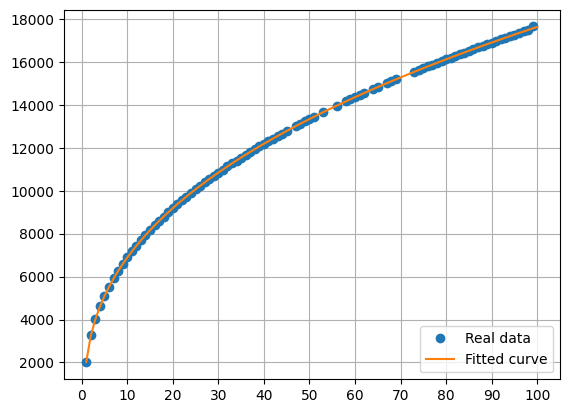

In [18]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import simpson as int_simpson, quad as int_quad
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Markdown
import pandas as pd
%matplotlib inline

def log_curve(x, a, b):
    return a * np.log(x) + b

def arctan_curve(x, a, b, ph, d):
    return a * np.arctan(b * x + ph)  + d

# This seems to be the winner (a + (x + d)^b)
# Keeping the other functions around for posterity
def power_curve(x, a, b, d):
    # Need to abs (x + d) because np is unhappy doing x^b if x is negative
    # We don't expect b >= 1, but it screws up the fit/test process
    return a * np.power(np.abs(x + d), b)

# Recording old fit curves for posterity in case the data changes significantly
snapshots = [
    { "date": "2022-12-10T21:22:15Z", "curve": power_curve, "params": [2.81728139e+03, 0.398507015, -0.577508009] },
    
    # After filling in most of the 60s and two 80 data points
    { "date": "2022-12-19T02:00:00Z", "curve": power_curve, "params": [2.81423065e+03, 0.398836145, -0.563087413] },
    
    { "date": "2022-12-27T03:34:00Z", "curve": power_curve, "params": [2.80905616e+03, 0.399351083, -0.557412915] },
]

curve_to_fit = power_curve

# Our data ("zippedData") is a list of (x, y) tuples which we need to rearrange
# into an x-list and y-list. We also build a "mapped" dictionary {x: y} at the same time.
lvls = []
tnlXp = []
mapped = {}
for (x, y) in zippedData:
    lvls.append(x)
    tnlXp.append(y)
    mapped[x] = y

# Fit our curve to the data; p0 is based on iteration from previous curves
pars, cov = opt.curve_fit(f=curve_to_fit, xdata=lvls, ydata=tnlXp, p0=[2800, 0.4,  -0.6], bounds=(-np.inf, np.inf))
displaymd("# Fitting a power curve to the XP-per-level data")
displaymd(f"**[a, b, d]** where *y = a\*(x + d)<sup>b</sup>*: **{pars}**")

# Generate a range of x-values over which to evaluate the curve
x_fit = np.linspace(1, 100, 101)

# Evaluate the curve at each x-value in the range
y_fit = curve_to_fit(x_fit, *pars)

# Plot our real data
plt.plot(lvls, tnlXp, "o", label="Real data")
# Plot our fitted data
plt.plot(x_fit, y_fit, label="Fitted curve")
plt.xticks(np.arange(0, 101, step=10))
plt.grid(which="major")
plt.legend(loc="lower right")
plt.show()

# Fitting power curves to the hourglass data

The hypothesis is that there are two curves here; one for "low" data (<4 wins) and one for "high" data (>=4 wins).

Low curve: **[a, b, y<sub>0</sub>]** where *y = a\*x<sup>b</sup> + y<sub>0</sub>*: **[803.34182678   1.54448152 296.65817322]**

High curve: **[a, b, y<sub>0</sub>]** where *y = a\*x<sup>b</sup> + y<sub>0</sub>*: **[ 3.0e+03  1.0e+00 -4.2e+03]**

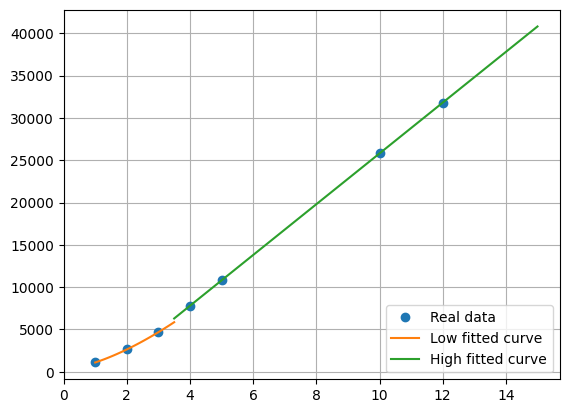

In [12]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import simpson as int_simpson, quad as int_quad
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Markdown
import pandas as pd
%matplotlib inline

# a*x^b + y0
def power_curve(x, a, b, y0):
    return a * np.power(x, b) + y0

curve_to_fit = power_curve

low_wins = [1, 2, 3]
low_gains = [1100, 2640, 4680]

high_wins = [4, 5, 10, 12]
high_gains = [7800, 10800, 25800, 31800]


# Fit our curve to the data
lowParams, lowCov = opt.curve_fit(f=curve_to_fit, xdata=low_wins, ydata=low_gains, p0=[1, 1,  0], bounds=(-np.inf, np.inf))
highParams, highCov = opt.curve_fit(f=curve_to_fit, xdata=high_wins, ydata=high_gains, p0=[lowParams[0], lowParams[1],  300], bounds=(-np.inf, np.inf))
displaymd("# Fitting power curves to the hourglass data")
displaymd("The hypothesis is that there are two curves here; one for \"low\" data (<4 wins) and one for \"high\" data (>=4 wins).")
displaymd(f"Low curve: **[a, b, y<sub>0</sub>]** where *y = a\*x<sup>b</sup> + y<sub>0</sub>*: **{lowParams}**")
displaymd(f"High curve: **[a, b, y<sub>0</sub>]** where *y = a\*x<sup>b</sup> + y<sub>0</sub>*: **{highParams}**")

# Generate a range of x-values over which to evaluate the curve
x_fit_low = np.linspace(1, 3.5)
x_fit_high = np.linspace(3.5, 15)

# Evaluate the curve at each x-value in the range
low_fit = curve_to_fit(x_fit_low, *lowParams)
high_fit = curve_to_fit(x_fit_high, *highParams)

# Plot our real data
plt.plot(low_wins + high_wins, low_gains + high_gains, "o", label="Real data")
# Plot our fitted data
plt.plot(x_fit_low, low_fit, label="Low fitted curve")
plt.plot(x_fit_high, high_fit, label="High fitted curve")
plt.xticks(np.arange(0, 15, step=2))
plt.grid(which="major")
plt.legend(loc="lower right")
plt.show()

In [19]:
import ipywidgets as widgets
import math

# For a tuple (from, to), this function computes how much XP/Allegiance is needed to progress.
# It returns a 3-tuple (real, fitted, integral):
# real: Mix of real data and fitted data where we're missing real data
# fitted: Sum of fitted data points only
# integral: Integrated fit curve
# Only "real" is practically useful, but the others are included to allow spot checks of the fit curve
def get_xp_values(levelRange):
    fromLevel, toLevel = levelRange
    
    # We'll use our curve-of-best-fit as well as our real data, where we have it.
    # Approximations counts how many times we defer to the fit line instead of using real data.
    approximations = 0
    realSum = 0
    fittedSum = 0
    for level in range(fromLevel, toLevel):
        fitted = curve_to_fit(level, *pars)
        if level in mapped:
            realSum += mapped[level]
        else:
            realSum += fitted
            approximations += 1
        fittedSum += fitted

    # Integrate the fit line for fun
    (integralSum, _error) = int_quad(lambda x: curve_to_fit(x, *pars), fromLevel, toLevel)  
    return ((realSum, approximations), fittedSum, integralSum)

# Calculate how long it takes to level over a given level range
def calculate_level_values(levelRange):
    ((realSum, approximations), fittedSum, integralSum) = get_xp_values(levelRange)
    fromLevel, toLevel = levelRange

    displaymd(f"## XP to level from {fromLevel} to {toLevel}")

    to100 = get_xp_values((1, 100))
    
    if approximations > 0:
        displaymd(f"**Best guess (real and fitted data):** {realSum:,.0f}, using {approximations:d} fitted levels")
    else:
        displaymd(f"**Real data:** {realSum:,d}")
        
    displaymd(f"**Fitted data only:** {fittedSum:,.0f}")
    displaymd(f"**Integral of fit curve:** {integralSum:,.0f}")

    displaymd("## Effort required")
    if fromLevel > 1 or toLevel != 100:
        displaymd(f"This is **{(100.0*realSum)/to100[0][0]:,.1f}%** of the amount to get from 1 to 100")
    farmedLossCount = math.ceil(realSum / GAIN_LOSS)
    minsPerLoss = 5
    displaymd(f"**Loss farming 👎**: {farmedLossCount:,.0f}")
    displaymd(f"Assuming {minsPerLoss} mins/loss, this is {farmedLossCount * minsPerLoss / 60.0:,.1f} hours")
    displaymd(f"**Individual wins** (no losses, hourglasses, flags, or streaks): {math.ceil(realSum / GAIN_WIN[0]):,.0f}")
    displaymd(f"**1-streak wins** (+hourglass, no losses, flags, or 'real' streaks): {math.ceil(realSum / (GAIN_WIN[0] + GAIN_HOURGLASS[0])):,.0f}")
    displaymd(f"**50/50 win/loss matches**: {math.ceil(2 * realSum / (GAIN_WIN[0] + GAIN_LOSS)):,.0f}")

levelSlider = widgets.IntRangeSlider(
    value=[1, 100],
    min=1,
    max=100,
    step=1,
    description="Levels"
)

widgets.interact(calculate_level_values, levelRange=levelSlider);

interactive(children=(IntRangeSlider(value=(1, 100), description='Levels', min=1), Output()), _dom_classes=('w…

In [5]:
# This cell declares a bunch of widgets used in the next cell, so that they aren't reset each time we evaluate that cell

modelSliderWidget = widgets.IntRangeSlider(
    value=levelSlider.value,
    min=1,
    max=100,
    step=1,
    description='Levels',
    continuous_update=False
)

winRateSlider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.05,
    description='Win rate:',
    continuous_update=False
)

grade1FlagWidget = widgets.BoundedFloatText(
    value=5,
    min=1,
    max=50.0,
    step=0.1,
    description='Grade 1 flag every N fights:',
)

bankSlider = widgets.IntSlider(
    value=4,
    min=1,
    max=len(GAIN_HOURGLASS),
    step=1,
    description='Bank streaks:',
    continuous_update=False
)

flagSlider = widgets.FloatSlider(
    value=0.25,
    min=0,
    max=1,
    step=0.05,
    description='Flag rate:',
    continuous_update=False
)

# TODO
merchantSuppliesButtons = widgets.SelectMultiple(
    options=['Storage crate', 'Cannon balls', 'Planks'],
    value=['Storage crate', 'Cannon balls', 'Planks'],
    description='Merchant:',
    #button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

# TODO
captaincySuppliesButtons = widgets.SelectMultiple(
    options=['Cannon balls', 'Planks', 'Throwables', 'Fruit', 'Meat'],
    value=['Cannon balls', 'Planks', 'Throwables', 'Fruit', 'Meat'],
    description='Captaincy:',
    #button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

In [10]:
from random import random

# Compute cost to do a full resupply each match
# TODO: Allow configuring resupply level
resupplyCost = 0
for source, inventory in SUPPLY_COSTS.items():
    for item, cost in inventory.items():
        resupplyCost += cost

def calculate_modeled_data(levelRange, winRate, bankAt, flagRate):
    #, merchantSupplies, captaincySupplies
    fromLevel, toLevel = levelRange
    
    GRADE_RATES = [1 - flagRate, flagRate*0.5, flagRate*0, flagRate*0.125, flagRate*0.125, flagRate*0.25]
    
    ((realSum, approximations), fittedSum, integralSum) = get_xp_values(levelRange)
    
    displaymd(f"## Sim from {fromLevel} to {toLevel}; {realSum:,.0f} XP required")
    displaymd(f"Assuming a win rate of **{winRate}**")
    displaymd(f"Banking hourglasses at **{bankAt}** wins")
    displaymd(f"Assuming **{resupplyCost:,d}** gold to resupply each loss (Merchant: storage crate, wood, cannons; Captaincy: All except worms)")
    displaymd(f"Assuming {EMI_MULTI_GRADE_3}x gold for grade 3 (1 win); {EMI_MULTI_GRADE_5}x for grade 5 (2+ wins)")
    displaymd(f"Assuming 0 bonus gold for sinking champions") # TODO?
    displaymd(f"Using the following weights for chances of each flag grade (first is no flag): **{GRADE_RATES}**")
    
    # TODO: Gold for lowering flags? Is that even worth tracking?
    
    # Computes various stats for a run from "fromLevel" to "toLevel" and returns them in a dictionary
    def sim():
        # We'll sim until this exceeds our requirement
        totalAllegiance = 0

        hourglasses = 0 # Number of banked hourglasses
        lostStreaks = 0 # Number of hourglasses we lost
        maxStreak = 0 # Largest win streak (separate from banked hourglasses)
        currentStreak = 0 # Current hourglass streak
        currentStreakUnbanked = 0 # Current win streak (separate from hourglasses)
        wins = 0 # Total wins
        losses = 0 # Total losses
        resupplyTotal = resupplyCost # Gold spent on resupplies; accumulates per loss
        currentHourglassGold = 0 # Current (unbanked) hourglass value
        hourglassBankedGold = 0 # Total gold we've earned from banking hourglasses
        flagGold = 0 # Total gold we've earned from selling emissary flags
        flagsSold = [0, 0, 0, 0, 0] # Count of each flag grade we've sold
        
        # Generate a large number of samples that represents emissary flag grades our enemies will use;
        # we'll pull from this list whenever we win a match.
        # We do this up front to save on perf, as generating a sample just-in-time is very expensive.
        enemyFlagGrades = np.random.choice([0, 1, 2, 3, 4, 5], 1000, True, GRADE_RATES)

        # Loop until we accumulate enough XP to hit the target level
        while totalAllegiance < realSum:
            # Did we win this match?
            if random() < winRate:
                # What flag was the enemy flying? 0 means no flag
                enemyFlagGrade = enemyFlagGrades[wins]
                wins += 1
                
                # Award allegiance based on our table
                totalAllegiance += GAIN_WIN[min(currentStreak, len(GAIN_WIN) - 1)]
                # Build up the hourglass based on our table
                currentHourglassGold += INCREMENTAL_HOURGLASS_GOLD[min(currentStreak, len(INCREMENTAL_HOURGLASS_GOLD) - 1)]
                
                currentStreak += 1
                currentStreakUnbanked += 1
                
                # Assume if we have 2+ unbroken wins that we're grade 5 emissary, otherwise grade 3
                # In practice, grade 4 after 1 win is also possible, but we'll be conservative
                emiMultiplier =  EMI_MULTI_GRADE_3 if currentStreakUnbanked == 1 else EMI_MULTI_GRADE_5
                
                if enemyFlagGrade > 0:
                    # Award gold for selling flag
                    flagValue = emiMultiplier * GOLD_FLAG_SELL[enemyFlagGrade - 1]
                    flagGold += flagValue
                    flagsSold[enemyFlagGrade - 1] += 1
                    
                    # Award Allegiance/XP for selling flag
                    totalAllegiance += GAIN_FLAG[enemyFlagGrade - 1]

                # Do we bank this win?
                if currentStreak >= bankAt:
                    # Award hourglass Allegiance
                    totalAllegiance += GAIN_HOURGLASS[min(currentStreak - 1, len(GAIN_HOURGLASS) - 1)]
                    hourglasses += 1
                    maxStreak = max(currentStreakUnbanked, maxStreak)
                    currentStreak = 0 # Reset the hourglass streak since we just banked
                    
                    # Bank hourglass gold
                    hourglassBankedGold += (emiMultiplier * currentHourglassGold)
                    currentHourglassGold = 0
            else:
                # Track if this loss killed a streak for us
                if currentStreak >= 1:
                    lostStreaks += 1
                maxStreak = max(currentStreakUnbanked, maxStreak)
                currentStreak = 0
                currentStreakUnbanked = 0
                currentHourglassGold = 0
                losses += 1
                
                # Dock gold for resupplying and award our loss XP
                resupplyTotal += resupplyCost
                totalAllegiance += GAIN_LOSS

        # Update our streak based on the most recent value after our loop
        maxStreak = max(currentStreakUnbanked, maxStreak)
        
        # Return a dictionary of stuff we might care about for analysis
        return { "Wins": wins, "Losses": losses,
                "MaxStreak": maxStreak, "BankedStreaks": hourglasses, "LostStreaks": lostStreaks,
                "ResupplySpend": float(resupplyTotal), "HourglassGold": hourglassBankedGold, "SoldFlagsGold": flagGold,
                "FlagsSold_1": flagsSold[0], "FlagsSold_2": flagsSold[1], "FlagsSold_3": flagsSold[2], "FlagsSold_4": flagsSold[3],"FlagsSold_5": flagsSold[4]}
    
    
    # Run 1000 trials and do some data magic
    data = pd.DataFrame([sim() for _ in range(1000)]);
    data["TotalNetGold"] = data["HourglassGold"] + data["SoldFlagsGold"] - data["ResupplySpend"]
    data["NetGoldPerMatch"] = data["TotalNetGold"] / (data["Wins"] + data["Losses"])
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data[["Wins", "Losses", "NetGoldPerMatch", "TotalNetGold", "HourglassGold", "SoldFlagsGold", "ResupplySpend"]].describe()
                .drop(["count", "25%", "75%"]) # Not interested in these rows
                .reindex(["mean", "50%", "min", "max", "std"])) # Rearrange 
        
    data.plot.hist(column=["Wins", "Losses"], bins=range(0, 300), grid=True)
    
    print()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data.head())
    
# TOOD: , merchantSupplies=merchantSuppliesButtons, captaincySupplies=captaincySuppliesButtons
widgets.interact_manual(calculate_modeled_data, levelRange=modelSliderWidget, winRate=winRateSlider, bankAt=bankSlider, flagRate=flagSlider);

interactive(children=(IntRangeSlider(value=(1, 100), continuous_update=False, description='Levels', min=1), Fl…